# 1. Introduction

We are interested in investigating the emergence of cyber threats and vulnerabilities using archived cyber-security data(CVE) and discussions related to it on Twitter.

The notebook is inspired by the work in the article [Vulnerability Disclosure in the Age of Social Media: Exploiting Twitter for Predicting Real-World Exploits](https://www.umiacs.umd.edu/~tdumitra/papers/USENIX-SECURITY-2015.pdf) where the idea is to use twitter analytics for early detecting exploits. There have been instances shared in the presentation, where vulnerabilities have been mentioned and discussed on twitter before the vulnerability is disclosed and this is the motivation for using twitter as a part of the research.

The tweets collected from cve_twitter_extraction.ipynb are further cleaned and used for analysis in this notebook.



# Method


Using search api we have extracted tweets related to keyword "CVE" in txt file which is in json format.Now from the tweets collected, we are trying to see how spread over time the tweets obtained via the Search API from a few samples are. Time series analysis helps in revealing unexpected trends and also to determine some helpful statistics.

# 2. Analysis

In the following code block we will load the text file into a variable searched_tweets_srch. The required information timestamp is present in the variable 'created_at'. We will use the libraries pandas to extract the variables and store them in a list Dates.   
The ouput shows the list of Dates with the all the dates stored in a timestamp format.

In [55]:

#import libraries
from twython import Twython, TwythonError
import time
from time import gmtime, strftime
import json
import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np

path_to_json="tweet_3_29_2018/"
json_files=[pos for pos in os.listdir(path_to_json) if pos.endswith('.json')]
json_data=pd.DataFrame(columns=['created_at'])
tweets=[]
dictlist=[]
Dates=[]
for js in json_files:
    with open(os.path.join(path_to_json, js)) as json_file:
        searched_tweets_srch = json.load(json_file)
        print(type(searched_tweets_srch))
        

        #Converting Twitter date to timestamp
        for key, value in searched_tweets_srch.items():
            time_struct=time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(searched_tweets_srch['created_at'],'%a %b %d %H:%M:%S +0000 %Y'))
            Dates.append(time_struct)
            print(Dates)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 16:50:32', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-29 17:00:30', '2018-03-

Next, we perform a resampling calculation to determine the number of tweets per minute. This is one of many functions that is supported by Pandas.

In [52]:
idx=pd.DatetimeIndex(Dates)
ones=np.ones(len(Dates))
my_series=pd.Series(ones,index=idx)
per_minute=my_series.resample('1Min').sum().fillna(0)


Finally, we will use the matplot library to create the graph and display it on the screen. Matplotlib.pyplot is a collection of command style functions that make matplotlib work like MATLAB. 

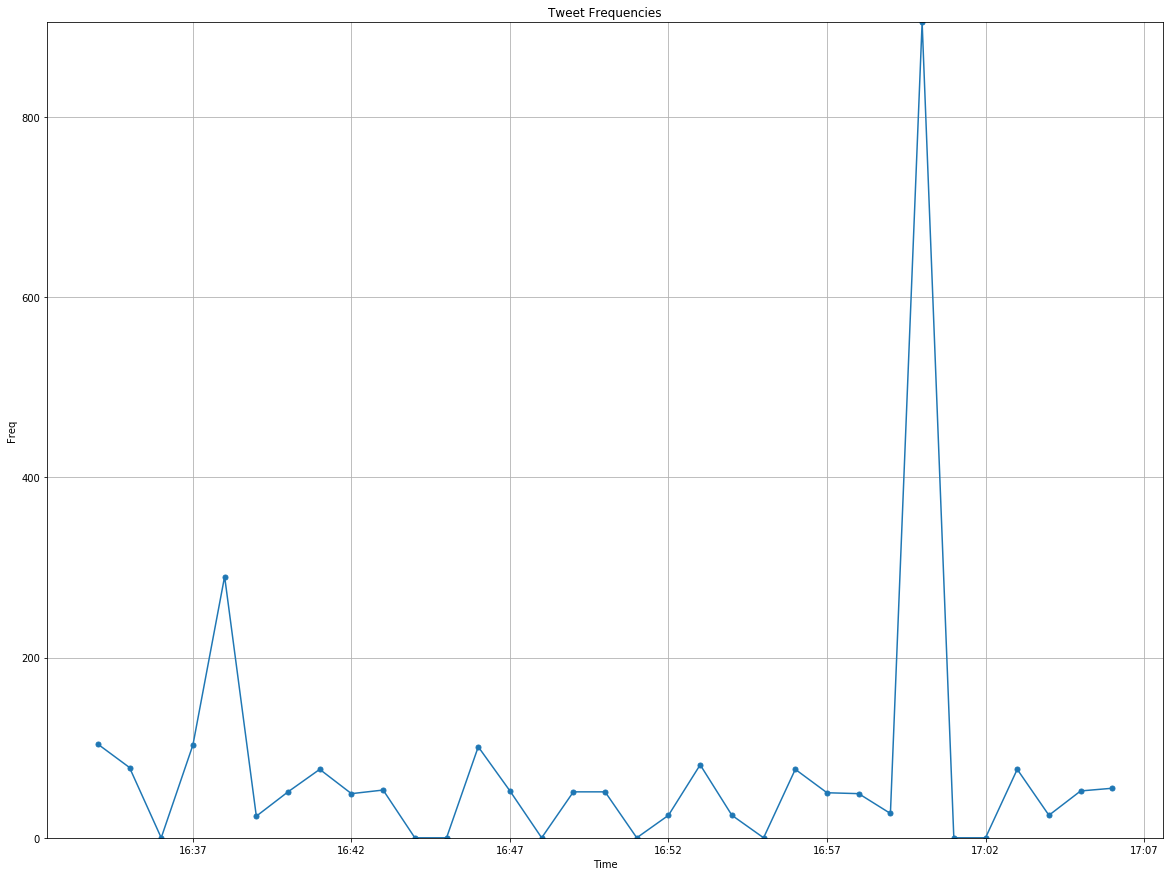

In [54]:
fig,ax=plt.subplots(figsize=(20,15))
ax.grid(True)
ax.set_title("Tweet Frequencies")
hours=mdates.MinuteLocator(interval=5)
date_formatter=mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(date_formatter)
max_freq=per_minute.max()
ax.set_ylim(0, max_freq)
ax.plot(per_minute.index,per_minute,marker='o',markersize=5)
plt.xlabel('Time')
plt.ylabel('Freq')
plt.show()

The plot shows the average tweets/minute for the search term "CVE" over a single day.